# Impact of correlation on SHAP values

In [1]:
import os
#import sys  # isort:skip

import pickle
from math import pi

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns 
import shap
from sklearn.metrics import auc, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
import sympy
# from sympy import cos, sin, symbols

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model


from synthetic_data.synthetic_data import make_tabular_data

### Set up random seed & plotting function for use later

In [2]:
def no_tick_labels(ax):
    ax.axes.get_xaxis().set_ticks([])  # suppress x tick labels
    ax.axes.get_yaxis().set_ticks([])
    return

def my_tricontour(ax, x1, x2, y, z, labels=None, title=None, levels=None, scatter=True, bar=True, ticks=True):
    tri2 = ax.tricontourf(x1, x2, z, levels=levels, cmap='afmhot_r')
    if scatter:
        scatter = ax.scatter(x1, x2, c=y, label=y, marker=".")
        #leg1 = ax.legend(*scatter.legend_elements(), loc="lower right", title="class")

    ax.set_title(title)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    
    ax.set_xlim([-1, 1]) 
    ax.set_ylim([-1, 1]) 
    
    if bar:
        cbar2 = fig.colorbar(tri2, ax=ax, fraction=0.046, pad=0.08,format='%.2f' )
        #cbar2.formatter.set_powerlimits((0, 0)) 
        cbar2.update_ticks()
    if not ticks:
        no_tick_labels(ax)
    # ax.set_aspect("equal", "box")
    ax.set_aspect("equal")
    return

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # or any {'0', '1', '2'}                                                   
# Set the seed for hash based operations in python
os.environ["PYTHONHASHSEED"] = "0" 
np.random.seed(111)
tf.random.set_seed(111)
seed = 1234

### Baseline data

In [3]:
# define symbols
# x1, x2 = symbols("x1 x2")

# define expression
expr = "cos(x1 ** 2 * pi / 180.0) - sin(x2 * pi / 180.0) + x1 * x2"

# define mapping from symbols to column of X - clunky TODO - make it better
col_map = {"x1": 0, "x2": 1}

# define correlations via covariance matrix
cov = np.array([[1.0, 0.0], [0.0, 1.0]])

n_samples = 1000
p_thresh = 0.5   # probability threshold to divide class 0 from class 1
# every other parameter is going to use the default - check docstring for completion

In [4]:
X, y_reg, y_prob, y_label = make_tabular_data(n_samples=n_samples, cov=cov, col_map=col_map, expr=expr, p_thresh=p_thresh, seed=seed)


### With correlation

In [5]:
cov_c = np.array([[1.0, 0.5], [0.5, 1.0]])

In [6]:
X_c, y_reg_c, y_prob_c, y_label_c = make_tabular_data(n_samples=n_samples, cov=cov_c, col_map=col_map, expr=expr, p_thresh=p_thresh, seed=seed)

### Let's see what we got!
#### Baseline features

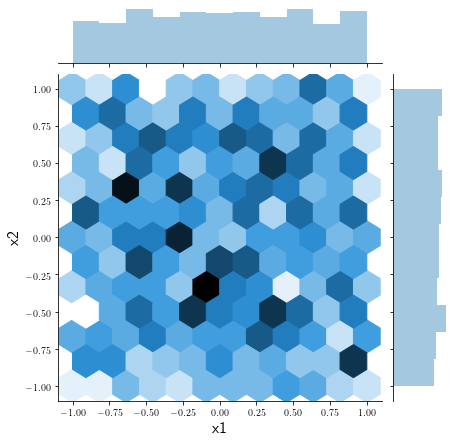

In [7]:
h = sns.jointplot(X[:, 0], X[:, 1], kind="hex", stat_func=None)
h.set_axis_labels("x1", "x2", fontsize=16)

#### Correlated features

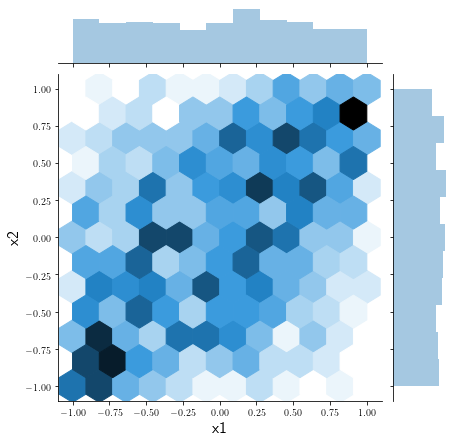

In [8]:
h = sns.jointplot(X_c[:, 0], X_c[:, 1], kind="hex", stat_func=None)
h.set_axis_labels("x1", "x2", fontsize=16)

## Let's check the impact on y_reg

Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.


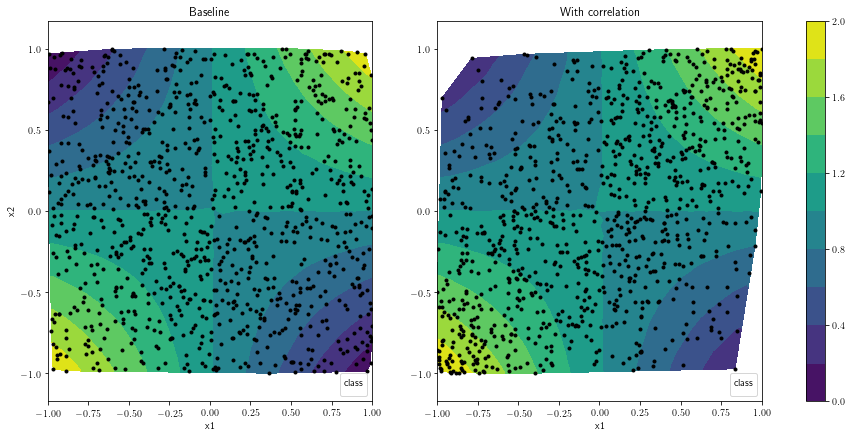

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(16, 7))
levels = np.arange(0, 2.2, 0.2)
#x1 = X[:, 0]
#x2 = X[:, 1]
#z = y_reg
#my_tricontour(ax[0], x1, x2, y_train, z, labels=["x1", "x2"], title="Baseline", levels=levels)

tri1 = ax[0].tricontourf(X[:, 0], X[:, 1], y_reg, levels=levels)
scatter = ax[0].scatter(X[:, 0], X[:, 1], c='k', label=y_label, marker=".")
leg1 = ax[0].legend(*scatter.legend_elements(), loc="lower right", title="class")
#cbar1 = fig.colorbar(tri1, ax=ax)
ax[0].set_title("Baseline")
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].axis('equal')
#cbar1.formatter.set_powerlimits((0, 0))
#cbar1.update_ticks()

tri1 = ax[1].tricontourf(X_c[:, 0], X_c[:, 1], y_reg_c, levels=levels)
scatter = ax[1].scatter(X_c[:, 0], X_c[:, 1], c='k', label=y_label, marker=".")
leg1 = ax[1].legend(*scatter.legend_elements(), loc="lower right", title="class")
cbar1 = fig.colorbar(tri1, ax=ax)
ax[1].set_title("With correlation")
ax[1].set_xlabel("x1")
ax[1].axis('equal')
#ax[1].set_ylabel("x2")
cbar1.formatter.set_powerlimits((0, 0))
cbar1.update_ticks()


You can see that the positive correlation has shifted density to the lower left and upper right.
But the contours remain in the same location (which is intended - the function f(X) doesn't change because we have correlation).

## Similar plots but with y_prob = sigmoid(y_reg)

This is the last step in the creation of our binary class labels.

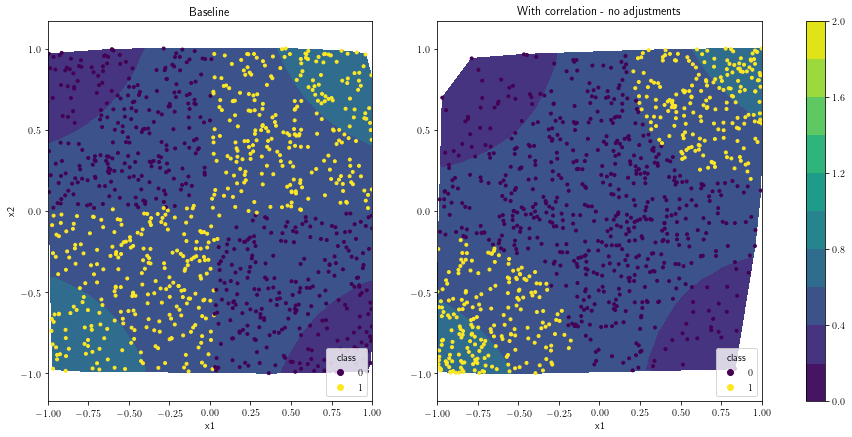

In [10]:
levels = np.arange(0, 2.2, 0.2)
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(16, 7))
tri1 = ax[0].tricontourf(X[:, 0], X[:, 1], y_prob, levels=levels)
scatter = ax[0].scatter(X[:, 0], X[:, 1], c=y_label, label=y_label, marker=".")
leg1 = ax[0].legend(*scatter.legend_elements(), loc="lower right", title="class")
#cbar1 = fig.colorbar(tri1, ax=ax)
ax[0].set_title("Baseline")
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].axis('equal')
#cbar1.formatter.set_powerlimits((0, 0))
#cbar1.update_ticks()

tri1 = ax[1].tricontourf(X_c[:, 0], X_c[:, 1], y_prob_c, levels=levels)
scatter = ax[1].scatter(X_c[:, 0], X_c[:, 1], c=y_label_c, label=y_label, marker=".")
leg1 = ax[1].legend(*scatter.legend_elements(), loc="lower right", title="class")
cbar1 = fig.colorbar(tri1, ax=ax)
ax[1].set_title("With correlation - no adjustments")
ax[1].set_xlabel("x1")
ax[1].axis('equal')
#ax[1].set_ylabel("x2")
#cbar1.formatter.set_powerlimits((0, 0))
cbar1.update_ticks()


### Wot?
Why don't our probabilities (and our labels) agree between the two plots?  
Answer: the sigmoid function has a parameter x_0 that 'centers' the sigmoid.
The default choice is `x_0 = np.mean(<some y_reg type vector here>)`


In [11]:
np.mean(y_reg)

0.99386746

In [12]:
np.mean(y_reg_c)

1.1478641

Those means are not the same, so the sigmoid won't be 'centered' the same way between the two datasets.

### Q: Are we generating balanced classes?

In [13]:
np.unique(y_label, return_counts=True)

(array([False,  True]), array([490, 510]))

In [14]:
np.unique(y_label_c, return_counts=True)

(array([False,  True]), array([595, 405]))

The baseline case with no correlation is balanced.  But the correlated case is skewed toward class 0.  So let's fix the value we use to center the sigmoid and recalculate...maybe that will rebalance the classes?

In [15]:
x_0_baseline = np.mean(y_reg)

In [16]:
X_3, y_reg_3, y_prob_3, y_label_3 = make_tabular_data(n_samples=n_samples, cov=cov_c, col_map=col_map, expr=expr, sig_x0=x_0_baseline, p_thresh=p_thresh)

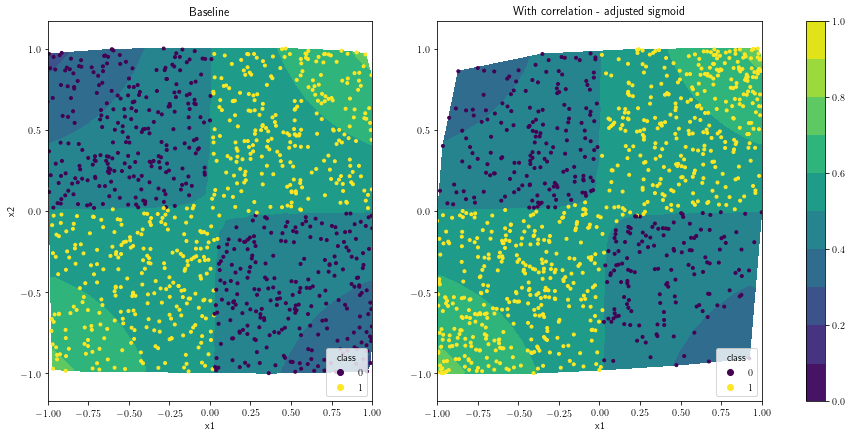

In [17]:
levels = np.arange(0, 1.1, 0.1)
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(16, 7))
tri1 = ax[0].tricontourf(X[:, 0], X[:, 1], y_prob, levels=levels)
scatter = ax[0].scatter(X[:, 0], X[:, 1], c=y_label, label=y_label, marker=".")
leg1 = ax[0].legend(*scatter.legend_elements(), loc="lower right", title="class")
#cbar1 = fig.colorbar(tri1, ax=ax)
ax[0].set_title("Baseline")
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].axis('equal')
#cbar1.formatter.set_powerlimits((0, 0))
#cbar1.update_ticks()

tri1 = ax[1].tricontourf(X_3[:, 0], X_3[:, 1], y_prob_3, levels=levels)
scatter = ax[1].scatter(X_3[:, 0], X_3[:, 1], c=y_label_3, label=y_label, marker=".")
leg1 = ax[1].legend(*scatter.legend_elements(), loc="lower right", title="class")
cbar1 = fig.colorbar(tri1, ax=ax)
ax[1].set_title("With correlation - adjusted sigmoid")
ax[1].set_xlabel("x1")
ax[1].axis('equal')
#ax[1].set_ylabel("x2")
#cbar1.formatter.set_powerlimits((0, 0))
cbar1.update_ticks()

### TADA! 

In [18]:
np.unique(y_label, return_counts=True)

(array([False,  True]), array([490, 510]))

In [19]:
np.unique(y_label_3, return_counts=True)

(array([False,  True]), array([319, 681]))

...but now we have significantly unbalanced the classes....no such thing as a free lunch.

In [20]:
# train test split both datasets
x_train, x_test, y_train, y_test = train_test_split(X, y_label, test_size=0.3, random_state=42)
x_cor_train, x_cor_test, y_cor_train, y_cor_test = train_test_split(X_3, y_label_3, test_size=0.3, random_state=42)

## Define models

In [21]:
act1 = "relu"
init1 = "he_normal"
act2 = "sigmoid"
init2 = "glorot_normal"


input = Input(shape=(2,))
x = Dense(16, activation=act1, kernel_initializer=init1)(input)
x = Dense(12, activation=act1, kernel_initializer=init1)(input)
x = Dense(8, activation=act1, kernel_initializer=init1)(x)
x = Dense(6, activation=act1, kernel_initializer=init1)(x)
x = Dense(2, activation=act1, kernel_initializer=init1)(x)
output = Dense(1, activation=act2, kernel_initializer=init2)(x)

base_model = Model(input, output)
base_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# save the compiled model so we can reuse the same network for the correlated data
base_model.save('base_arch.h5') # saves compiled state
cor_model = load_model('base_arch.h5')

### Fit models

In [22]:
base_model.fit(x_train, y_train, epochs=80, batch_size=100, shuffle=True, validation_data=(x_test, y_test),verbose=0)


In [23]:
cor_model.fit(x_cor_train, y_cor_train, epochs=80, batch_size=100, shuffle=True, validation_data=(x_cor_test, y_cor_test),verbose=0)

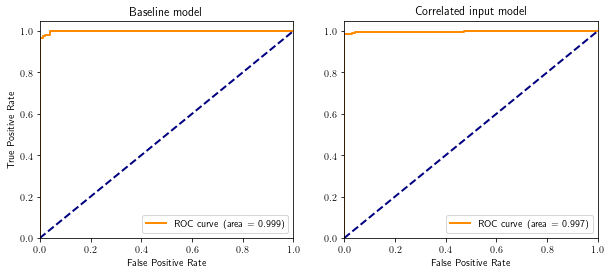

In [24]:
# calculate ROC curve and AUC...
y_test_pred = base_model.predict(x_test)
y_cor_test_pred = cor_model.predict(x_cor_test)
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
fpr_cor, tpr_cor, _ = roc_curve(y_cor_test, y_cor_test_pred)
roc_auc = auc(fpr, tpr)
roc_auc_cor = auc(fpr_cor, tpr_cor)
#print(f"Model AUC = {roc_auc:5.3f}")

lw = 2
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].plot(fpr, tpr, color="darkorange", lw=lw, label=f"ROC curve (area = {roc_auc:4.3f})")
ax[0].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
ax[0].set_xlim([0.0, 1.0])                                                                                                 
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("Baseline model")
ax[0].legend(loc="lower right")

ax[1].plot(fpr_cor, tpr_cor, color="darkorange", lw=lw, label=f"ROC curve (area = {roc_auc_cor:4.3f})")
ax[1].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
ax[1].set_xlim([0.0, 1.0])                                                                                                 
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel("False Positive Rate")
#ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("Correlated input model")
ax[1].legend(loc="lower right")

## SHAP values

In [25]:
exp = shap.DeepExplainer(base_model, x_train)
local_attr_list = exp.shap_values(x_train)
local_attr = np.array(local_attr_list).squeeze()

exp = shap.DeepExplainer(cor_model, x_cor_train)
local_attr_list = exp.shap_values(x_cor_train)
local_attr_cor = np.array(local_attr_list).squeeze()

features = ["x1", "x2"]

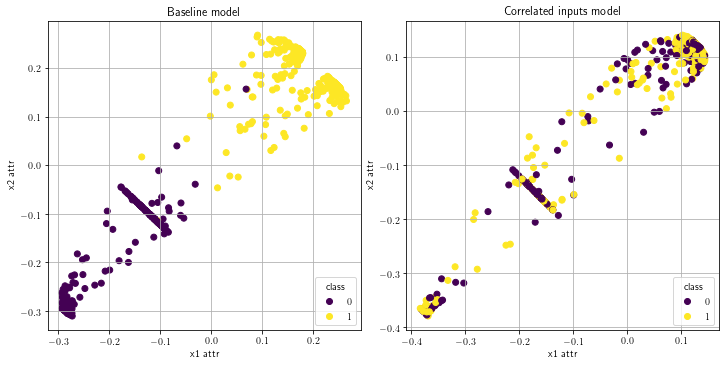

In [26]:
# scatter plot of attributions
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

scatter1 = ax[0].scatter(local_attr[:, 0], local_attr[:, 1], c=y_train, label=y_train)
ax[0].legend(*scatter1.legend_elements(), loc="lower right", title="class")
ax[0].set_xlabel("x1 attr")
ax[0].set_ylabel("x2 attr")
ax[0].set_title('Baseline model')
ax[0].grid()

ax[1].scatter(local_attr_cor[:, 0], local_attr_cor[:, 1], c=y_train, label=y_train)
ax[1].legend(*scatter1.legend_elements(), loc="lower right", title="class")
ax[1].set_xlabel("x1 attr")
ax[1].set_ylabel("x2 attr")
ax[1].set_title('Correlated inputs model')
ax[1].grid()

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


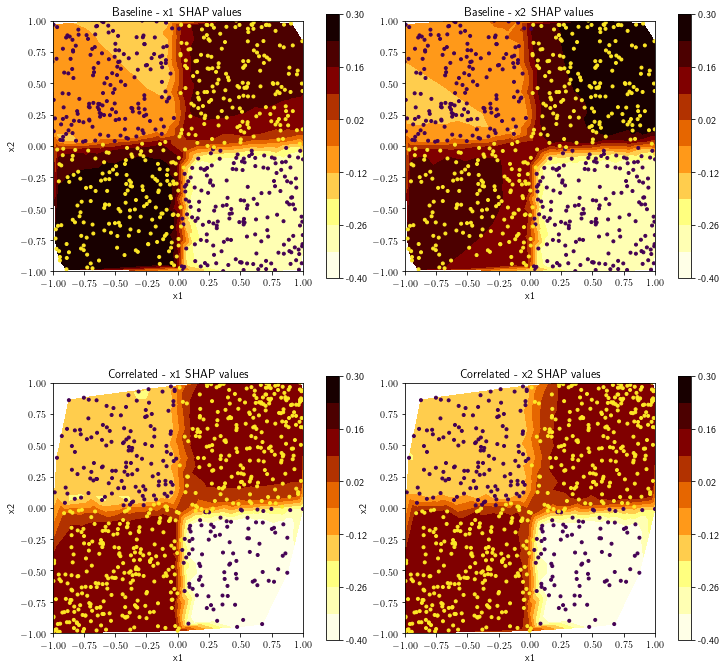

In [27]:
# contour map of attributions
levels = np.linspace(-0.4,0.3, 11)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
x1 = x_train[:, 0]
x2 = x_train[:, 1]
z = local_attr[:, 0]
my_tricontour(ax[0,0], x1, x2, y_train, z, labels=["x1", "x2"], title="Baseline - x1 SHAP values", levels=levels)

z = local_attr[:, 1]
my_tricontour(ax[0,1], x1, x2, y_train, z, labels=["x1", ""], title="Baseline - x2 SHAP values", levels=levels)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# correlated inputs
x1 = x_cor_train[:, 0]
x2 = x_cor_train[:, 1]
z = local_attr_cor[:, 0]
my_tricontour(ax[1,0], x1, x2, y_cor_train, z, labels=["x1", "x2"], title="Correlated - x1 SHAP values", levels=levels)

z = local_attr_cor[:, 1]
my_tricontour(ax[1,1], x1, x2, y_cor_train, z, labels=["x1", "x2"], title="Correlated - x2 SHAP values", levels=levels)

In [28]:
# TODO - if average output is different - provide consistent background to train explainer
y_train_pred = base_model.predict(x_train)
y_train_pred.mean()

0.5871359

In [29]:
y_cor_train_pred = cor_model.predict(x_cor_train)
y_cor_train_pred.mean()

0.748404

Since SHAP values are based on the expected model output - and we've shown that it's skewed with correlated input features - what if we retrain the explainer for the correlated model with uncorrelated data?  (In other words - in the presence of correlation - did the model itself learn a different representation?)

In [30]:
x1_tmp = np.arange(-1, 1, 0.1)
x2_tmp = np.arange(-1, 1, 0.1)
m_grid = np.meshgrid(x1_tmp, x2_tmp, indexing="xy")
background = np.vstack([m_grid[0].ravel(), m_grid[1].ravel()]).T
background_pred = base_model.predict(background)
background_labels = background_pred > 0.5

In [31]:
# exp = shap.DeepExplainer(base_model, background)
# local_attr_list = exp.shap_values(x_train)
# local_attr = np.array(local_attr_list).squeeze()

exp_cor_refit = shap.DeepExplainer(cor_model, background)
local_attr_list = exp_cor_refit.shap_values(background)
local_attr_cor_refit = np.array(local_attr_list).squeeze()

In [32]:
# contour map of attributions
# levels = np.linspace(-0.4,0.3, 11)
# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
# fig.suptitle('SHAP explainers trained on consistent background')
# x1 = x_train[:, 0]
# x2 = x_train[:, 1]
# z = local_attr[:, 0]
# my_tricontour(ax[0,0], x1, x2, y_train, z, labels=["x1", "x2"], title="Baseline - x1 SHAP values", levels=levels)

# z = local_attr[:, 1]
# my_tricontour(ax[0,1], x1, x2, y_train, z, labels=["x1", ""], title="Baseline - x2 SHAP values", levels=levels)
# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# # correlated inputs
# x1 = x_cor_train[:, 0]
# x2 = x_cor_train[:, 1]
# z = local_attr_cor[:, 0]
# my_tricontour(ax[1,0], x1, x2, y_cor_train, z, labels=["x1", "x2"], title="Correlated - x1 SHAP values", levels=levels)

# z = local_attr_cor[:, 1]
# my_tricontour(ax[1,1], x1, x2, y_cor_train, z, labels=["x1", "x2"], title="Correlated - x2 SHAP values", levels=levels)

When we fit explainers for each model, using a consistent set of (x_1, x_2_ pairs, the SHAP values are essentially identical.  So remember, the explanations are not just from your model, they are conditioned on the data for which the explainer is trained.

In [33]:
# local_attr_list = exp.shap_values(background)
# local_attr = np.array(local_attr_list).squeeze()

# local_attr_list = exp_cor_refit.shap_values(background)
# local_attr_cor = np.array(local_attr_list).squeeze()

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
# levels = np.linspace(-0.05,0.05, 11)

# x1 = background[:, 0]
# x2 = background[:, 1]
# z = local_attr_cor[:, 0] - local_attr[:, 0]
# my_tricontour(ax[0], x1, x2, background_labels, z, labels=["x1", "x2"], title="delta - x1 SHAP values", levels=levels)

# z = local_attr_cor[:, 1] - local_attr[:, 1]
# my_tricontour(ax[1], x1, x2, background_labels, z, labels=["x1", ""], title="delta - x2 SHAP values", levels=levels)


# Side by side comparison - baseline, cov, cov refit

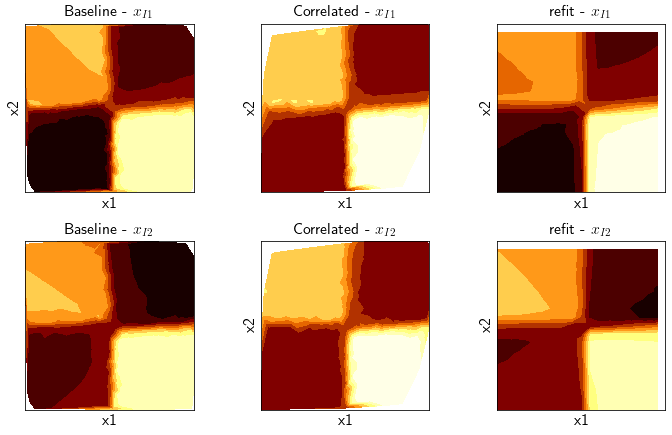

In [40]:
SMALL = 14
MEDIUM = 16
LARGE = 18

plt.rc('text', usetex=True)
plt.rc("font", size=SMALL)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL)  # legend fontsize
plt.rc("figure", titlesize=LARGE)  # fontsize of the figure title


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
# baseline
levels = np.linspace(-0.4,0.3, 11)
x1 = x_train[:, 0]
x2 = x_train[:, 1]
z = local_attr[:, 0]
my_tricontour(ax[0,0], x1, x2, y_train, z, labels=["x1", "x2"], title="Baseline - $x_{I1}$", levels=levels, scatter=False, bar=False, ticks=False)

z = local_attr[:, 1]
my_tricontour(ax[1,0], x1, x2, y_train, z, labels=["x1", ""], title="Baseline - $x_{I2}$", levels=levels, scatter=False, bar=False, ticks=False)


# correlated inputs
x1 = x_cor_train[:, 0]
x2 = x_cor_train[:, 1]
z = local_attr_cor[:, 0]
my_tricontour(ax[0,1], x1, x2, y_cor_train, z, labels=["x1", "x2"], title="Correlated - $x_{I1}$", levels=levels, scatter=False, bar=False, ticks=False)

z = local_attr_cor[:, 1]
my_tricontour(ax[1,1], x1, x2, y_cor_train, z, labels=["x1", "x2"], title="Correlated - $x_{I2}$", levels=levels, scatter=False, bar=False, ticks=False)

# correlated - refit
x1 = background[:, 0]
x2 = background[:, 1]
z = local_attr_cor_refit[:, 0]
my_tricontour(ax[0,2], x1, x2, background_labels, z, labels=["x1", "x2"], title="refit - $x_{I1}$", levels=levels, scatter=False, bar=False, ticks=False)

z = local_attr_cor_refit[:, 1]
my_tricontour(ax[1,2], x1, x2, background_labels, z, labels=["x1", "x2"], title="refit - $x_{I2}$", levels=levels, scatter=False, bar=False, ticks=False)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.savefig('correlated_inputs_summary.png')

In [ ]:
background.shape

In [ ]:
z.shape

In [ ]:
local_attr_cor_refit.shape
